In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Inputs

### Input - City, ¿add pop data? and resolution of output

In [2]:
city = 'Guadalajara'
# Create hexgrid with population data?
pop_output = True
# Resolutions of hexgrid output
# if pop_output = True, res can only be set to 8 or 9.
res_list = [8,9] }


### Input - mun_gdf / Area of interest (aoi)

In [3]:
# Creates empty GeoDataFrame to store specified municipality polygons
mun_gdf = gpd.GeoDataFrame()

# Iterates over municipality codes for each metropolitan area or capital
# Downloads municipality polygon according to code
query = f"SELECT * FROM metropolis.metro_gdf WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
 
#Define projections
mun_gdf = mun_gdf.set_crs("EPSG:4326")

<Axes: >

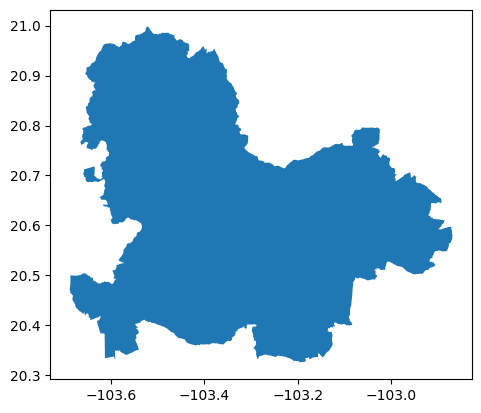

In [17]:
aoi = mun_gdf.dissolve()

# Show
aoi.plot()

### Input - Points of interest (pois)

In [7]:
paradas_dir = "../../data/external/temporal_todocker/amg_tp_paradas.gpkg"
estaciones_dir = "../../data/external/temporal_todocker/amg_tpmasivo_estaciones.gpkg"

# Read points of interest (pois)
paradas = gpd.read_file(paradas_dir)
estaciones = gpd.read_file(estaciones_dir)

# Set code for proximity analysis
paradas['code']  = 1
estaciones['code'] = 2

# Merge pois data
paradas = paradas[['code','geometry']]
estaciones = estaciones[['code','geometry']]
pois = pd.concat([paradas, estaciones])
pois = pois.set_crs("EPSG:4326")

# Show
print(pois.shape)
pois.head(2)

(9345, 2)


,code,geometry
0,1,POINT (-103.27734 20.67448)
1,1,POINT (-103.29438 20.67253)


### Input - Parameters and source_weight dictionaries

In [23]:
#--------------- PREPARE DATA ---------- SET PARAMETER AND WEIGHT
    #This step sets the ejes, amenidades, sources and codes for further analysis
            #{Eje (e):
            #            {Amenity (a):
            #                          {Sources (s):
            #                                           [Codes (c)]
            #                           }
            #             }
            #}
parameters = {'Transporte':{'Regular':{'paradas_tp':[1]},
                            'Masivo':{'estaciones_tpmasivo':[2]}
                           }
             }

source_weight = {'Transporte':{'Regular':'min',
                               'Masivo':'min'}
                }


## Step 1: Create Network

In [5]:
#Downloads street network from base
G, nodes, edges = aup.graph_from_hippo(mun_gdf, 'osmnx')

## Step 2: Calculate distance from each poi to nearest node (osmid)

In [21]:
# Filter pois for aoi
pois_aoi = gpd.sjoin(pois,aoi,how='inner')
pois = pois_aoi[['code','geometry']]

# Format to calculate nearest
nodes_gdf = nodes.set_crs("EPSG:4326")
edges_gdf = edges.set_crs("EPSG:4326")

# Calculate nearest
nearest = aup.find_nearest(G, nodes_gdf, pois, return_distance= True)

#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Calculated distances from pois to nearest node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Calculated distances from pois to nearest node.


## Step 3: Calculate distance to nearest source amenity for each node

In [24]:
# Create sources - code dicc out of main parameters dicc
sources = {}
for eje in parameters.keys():
    for amenity in parameters[eje]:
        for source in parameters[eje][amenity]:
            sources[source] = parameters[eje][amenity][source]

# Format
pois_distance_node = nearest.copy()
edges_gdf['length'].fillna(edges_gdf['length'].mean(),inplace=True)

# ELEMENTS NEEDED OUTSIDE THE LOOP - nodes_analysis is a nodes_gdf out of loop used in aup.calculate_distance_nearest_poi in each loop
nodes_analysis = nodes_gdf.reset_index().copy()
# ELEMENTS NEEDED OUTSIDE THE LOOP - nodes_sources is a nodes_gdf out of loop used to accumulate a final gdf with the minimal distance from each node to each source
nodes_sources = gpd.GeoDataFrame()
# ELEMENTS NEEDED OUTSIDE THE LOOP - Count
i = 0

# Loop that calculates distance from each node to each source (source by source)
for s in sources:
    
    # Locate pois data for current source
    source_gdf = gpd.GeoDataFrame()
    for cod in sources[s]:
        source_tmp = pois_distance_node[pois_distance_node['code']==cod]
        source_gdf = pd.concat([source_gdf,source_tmp])
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Loaded a total of {len(source_gdf)} points of interest of the source {s} for analisis.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    # Data for current amenity loop - df_temp: Each column will be a batch of procesed nodes.
    df_temp = nodes_gdf.copy()
    # Data for current amenity loop - nodes_distance: Minimum time/distance found in all batches will be added from df_min (within if/elif/else) to nodes_distance and finally to nodes_sources (outside loop)
    nodes_distance = nodes_gdf.copy()
    
    # In case there are no amenities of a certain type in the city
    if len(source_gdf) == 0:
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = 0
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"0 points of interest of the source {s} found, time is NaN.")
        #-------------------------------------------------------------------------------------------------------------------------------------------------       
    
    # Elif, divide in batches processing (200 if the total number of pois is an exact multiple of 250, 250 otherwise)
    elif len(source_gdf) % 250:
        batch_size = len(source_gdf)/200
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k} of {int(batch_size)} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = source_gdf.iloc[int(200*k):int(200*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_gdf, s, 'osmid', wght='length')
            
            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]
            
            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
            
        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
        
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)
        
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
        
        #Final data gets converted to time, assuming a walking speed of 4km/hr
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000
        
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Calculated time from nodes to pois for a total of {len(nodes_distance)} nodes for source {s}.")
        #------------------------------------------------------------------------------------------------------------------------------------------------- 

    # Else, divide in batches processing (200 if the total number of pois is an exact multiple of 250, 250 otherwise)   
    else:
        batch_size = len(source_gdf)/250
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k} of {int(batch_size)} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = source_gdf.iloc[int(250*k):int(250*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_gdf, s, 'osmid', wght='length')
            
            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]
            
            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
            
        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
        
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)
        
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
        
        #Final data gets converted to time, assuming a walking speed of 4km/hr
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000
    
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Calculated time from nodes to pois for a total of {len(nodes_distance)} nodes for source {s}.")
        #-------------------------------------------------------------------------------------------------------------------------------------------------    
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Applying final formating to calculated nodes.")
    #----------------------------------------------------------------------------------------------------------------------------------------------------- 
    
    #Format nodes_distance
    nodes_time['source'] = s
    nodes_time['city'] = city
    nodes_time.reset_index(inplace=True)
    nodes_time = nodes_time.set_crs("EPSG:4326")
    nodes_time = nodes_time[['osmid','time','source','city','x','y','geometry']]
    
    #If it is the first round nodes_sources is created equal to nodes_distance (all nodes, one source)
    #If it is the second or more, the new nodes_distance is merged.
    #This way we obtain the final gdf of interest that will contain the minimum disstance to each type of amenity by column.
    if i == 0:
        nodes_sources = nodes_time.copy()
    else:
        nodes_sources = pd.concat([nodes_sources,nodes_time])
        
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Added time for source {s} to nodes_sources.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    i += 1

Loaded a total of 9203 points of interest of the source paradas_tp for analisis.
Starting range k = 0 of 46 for source paradas_tp.
Starting range k = 1 of 46 for source paradas_tp.
Starting range k = 2 of 46 for source paradas_tp.
Starting range k = 3 of 46 for source paradas_tp.
Starting range k = 4 of 46 for source paradas_tp.
Starting range k = 5 of 46 for source paradas_tp.
Starting range k = 6 of 46 for source paradas_tp.
Starting range k = 7 of 46 for source paradas_tp.
Starting range k = 8 of 46 for source paradas_tp.
Starting range k = 9 of 46 for source paradas_tp.
Starting range k = 10 of 46 for source paradas_tp.
Starting range k = 11 of 46 for source paradas_tp.
Starting range k = 12 of 46 for source paradas_tp.
Starting range k = 13 of 46 for source paradas_tp.
Starting range k = 14 of 46 for source paradas_tp.
Starting range k = 15 of 46 for source paradas_tp.
Starting range k = 16 of 46 for source paradas_tp.
Starting range k = 17 of 46 for source paradas_tp.
Starting ra

## Step 4 - Analize distance data by nodes to proximity in hexagons

### Step 4 - Transform nodes data

In [26]:
nodes = nodes_sources.copy()

#--------------- PREPARE DATA
#--------------- PREPARE DATA ---------- DELETE DUPLICATES AND CLEAN NODES
#This step keeps osmid, geometry and metropolis (without duplicates, keeping only one point for each node) to store times to each amenity source by node in following loop.
nodes_geom = nodes.drop_duplicates(subset='osmid', keep="last")[['osmid','geometry','city']].copy()

#--------------- PREPARE DATA ---------- REORGANIZE NODES DATA
#This step organizes data by nodes by changing (time to source amenities) from rows (1 column with source amenity name + 1 column with time data) 
#to columns (1 column with time data named after its source amenity)
nodes_analysis = nodes_geom.copy()

for source_amenity in list(nodes.source.unique()):
    nodes_tmp = nodes.loc[nodes.source == source_amenity,['osmid','time']]
    nodes_tmp = nodes_tmp.rename(columns={'time':source_amenity})
    # Search for amenities that aren't present in the city (with all values marked as 0) and change them to NaN
    if nodes_tmp[source_amenity].mean() == 0:
        nodes_tmp[source_amenity] = np.nan
    nodes_analysis = nodes_analysis.merge(nodes_tmp, on='osmid')
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Transformed nodes data.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Transformed nodes data.


### Step 4 - Create definitions (previously idx_15min) dicc

In [27]:
# Create definitions dicc out of main parameters dicc:
definitions = {}
for eje in parameters.keys():
    # Temporary dicc stores amenity:[source_list] for each eje
    tmp_dicc = {}
    
    for amenity in parameters[eje]:
        items_lst = []
        items = list(parameters[eje][amenity].items())
        
        for item in items:
            items_lst.append(item[0])
            
        tmp_dicc[amenity] = items_lst
     
    # Each eje gets assigned its own tmp_dicc
    definitions[eje] = tmp_dicc

### Step 4 - Fill for missing amenities

In [28]:
#--------------- PREPARE DATA ---------- FILL MISSING COLUMNS (In case there is a source amenity not available in a city)
all_sources = []

# Gather all possible sources
for eje in definitions.keys():
    for amenity in definitions[eje].values():
        for source in amenity:
            all_sources.append(source)
            
# If source not in currently analized city, fill column with np.nan
column_list = list(nodes_analysis.columns)
missing_sourceamenities = []

for s in all_sources:
        if s not in column_list:
            nodes_analysis[s] = np.nan
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"{s} source amenity is not present in {city}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            missing_sourceamenities.append(s)
            
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Finished missing source amenities analysis. {len(missing_sourceamenities)} not present source amenities were added as np.nan columns")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Finished missing source amenities analysis. 0 not present source amenities were added as np.nan columns


### Step 4 - Amenities analysis

In [30]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Starting proximity to amenities analysis by node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

#--------------- PROCESS DATA 
#--------------- PROCESS DATA ---------- Max time calculation
#This step calculates times by amenity

column_max_all = [] # list with all max index column names
column_max_ejes = [] # list with ejes index column names

#Goes through each eje in dictionary:
for e in definitions.keys():

    #Appends to 3 lists currently examined eje
    column_max_all.append('max_'+ e.lower())
    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje

    #Goes through each amenity of current eje:
    for a in definitions[e].keys():

        #Appends to 2 lists currently examined amenity:
        column_max_all.append('max_'+ a.lower())
        column_max_amenities.append('max_'+ a.lower())

        #Calculates time to currently examined amenity:
        #If weight is less than number of sources of amenity, choose minimum time to sources.
        if source_weight[e][a] == 'min': 
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[definitions[e][a]].min(axis=1)
        #Else, choose maximum time to sources.
        else:
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[definitions[e][a]].max(axis=1)

    #Calculates time to currently examined eje (max time of its amenities):
    nodes_analysis['max_'+ e.lower()] = nodes_analysis[column_max_amenities].max(axis=1) 

index_column = 'max_time' # column name for maximum time data

#Add to column_max_all list the attribute 'max_time'
column_max_all.append(index_column)

#Assigns "max_time" the max time for all ejes
nodes_analysis[index_column] = nodes_analysis[column_max_ejes].max(axis=1)     

#Add to column_max_all list the attributes 'osmid' and 'geometry' to filter nodes_analysis with the column_max_all list.
column_max_all.append('osmid')
column_max_all.append('geometry')
nodes_analysis_filter = nodes_analysis[column_max_all].copy()
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Calculated proximity to amenities data by node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Starting proximity to amenities analysis by node.
Calculated proximity to amenities data by node.


### Step 4 - Group by hex (mean data)

In [35]:
res = 9
schema = 'censo'
table = f'hex_censo_mza_2020_res{res}'

# Iterates over municipality codes for each metropolitan area or capital
# Downloads municipality polygon according to code
query = f"SELECT * FROM {schema}.{table} WHERE \"metropolis\" LIKE \'{city}\'"
hex_socio_gdf = aup.gdf_from_query(query, geometry_col='geometry')
 
# Format before analysis
hex_pop = hex_socio_gdf.set_crs("EPSG:4326")
hex_tmp = hex_pop[[f'hex_id_{res}','geometry']].copy()

In [36]:
hex_idx = gpd.GeoDataFrame()

# group data by hex
hex_res_idx = aup.group_by_hex_mean(nodes_analysis_filter, hex_tmp, res, index_column)
hex_res_idx = hex_res_idx.loc[hex_res_idx[index_column]>0].copy()

#-----------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Grouped nodes data by hexagons res {res}")
#-----------------------------------------------------------------------------------------------------------------------------------------------------

# Add pop data
pop_list = [f'hex_id_{res}','pobtot','dens_pob_ha']
hex_res_pop = pd.merge(hex_res_idx, hex_pop[pop_list], on=f'hex_id_{res}')

# After funtion group_by_hex_mean we can remove res from ID and set as a column
hex_res_pop.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
hex_res_pop['res'] = res

hex_idx = hex_idx.append(hex_res_pop)
        
#-----------------------------------------------------------------------------------------------------------------------------------------------------    
print(f"Saved grouped data by hexagons res {res}")
#-----------------------------------------------------------------------------------------------------------------------------------------------------

Grouped nodes data by hexagons res 9
Saved grouped data by hexagons res 9


### Step 4 - Recalculate ejes max times by hexagon

In [37]:
#--------------- PROCESS DATA ---------- RE-CALCULATE MAX TIMES BY HEXAGON (ALL)
# This step recalculates max time to each eje from max times to calculated amenities and max_time from max eje
column_max_ejes = [] # list with ejes index column names

#Goes (again) through each eje in dictionary:
for e in definitions.keys():

    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje

    #Goes (again) through each amenity of current eje:    
    for a in definitions[e].keys():

        column_max_amenities.append('max_'+ a.lower())

    #Re-calculates time to currently examined eje (max time of its amenities):        
    hex_idx['max_'+ e.lower()] = hex_idx[column_max_amenities].max(axis=1)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
print('Finished recalculating times in hexagons')
#-----------------------------------------------------------------------------------------------------------------------------------------------------   

Finished recalculating times in hexagons


### Step 4 - Calculate index and add aditional data

In [38]:
#--------------- PROCESS DATA ---------- INDEX, MEDIAN AND MEAN CALCULATION (ALL)

#Define function
def apply_sigmoidal(x):
    if x == -1:
        return -1
    elif x > 1000:
        return 0
    else:
        val = aup.sigmoidal_function(0.1464814753435666, x, 30)
        return val

#Apply function to amenities columns without ejes ---------------------------------------------///// En lugar de pasarle la lista de amenidades, se crea la lista de amenidades desde column_max_all
max_amenities_cols = [i for i in column_max_all if i not in column_max_ejes]
max_amenities_cols.remove('max_time')
max_amenities_cols.remove('osmid')
max_amenities_cols.remove('geometry')

idx_amenities_cols = [] # list with idx amenity column names
for ac in max_amenities_cols:
    idx_col = ac.replace('max','idx')
    hex_idx[idx_col] = hex_idx[ac].apply(apply_sigmoidal)
    idx_amenities_cols.append(idx_col)

# Add final data
hex_idx[index_column] = hex_idx[column_max_ejes].max(axis=1)
hex_idx['mean_time'] = hex_idx[max_amenities_cols].mean(axis=1)
hex_idx['median_time'] = hex_idx[max_amenities_cols].median(axis=1)
hex_idx['idx_sum'] = hex_idx[idx_amenities_cols].sum(axis=1)
hex_idx['city'] = city
#-----------------------------------------------------------------------------------------------------------------------------------------------------    
print('Finished calculating index, mean and median time')
#-----------------------------------------------------------------------------------------------------------------------------------------------------

Finished calculating index, mean and median time


### Step 4 - Final format

In [40]:
#--------------- FINAL FORMAT ----------
#--------------- FINAL FORMAT ---------- REORDER COLUMNS

# First elements of ordered list - ID and geometry
first_elements = ['hex_id','res','geometry']

# Second elements of ordered list - max_ejes and max_amenities removing max_time, osmid and geometry.
column_max_ejes_amenities = column_max_all.copy()
column_max_ejes_amenities.remove('max_time')
column_max_ejes_amenities.remove('osmid')
column_max_ejes_amenities.remove('geometry')

# Third elements of ordered list are listed in idx_amenities_cols

# Fourth elements of ordered list - Mean, median, max and idx
fourth_elements = ['mean_time', 'median_time', 'max_time', 'idx_sum']

# Fifth elements - If pop is calculated - Pop data
fifth_elements = ['pobtot', 'dens_pob_ha']

# Last element - City data
last_element = ['city']

final_column_ordered_list = first_elements + column_max_ejes_amenities + idx_amenities_cols + fourth_elements + fifth_elements + last_element
    
hex_idx_city = hex_idx[final_column_ordered_list]
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print('Finished final format')
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Finished final format


In [41]:
hex_idx_city.head(2)

,hex_id,res,geometry,max_transporte,max_regular,max_masivo,idx_regular,idx_masivo,mean_time,median_time,max_time,idx_sum,pobtot,dens_pob_ha,city
0,8949aa252bbffff,9,"POLYGON ((-103.40480 20.46253, -103.40358 20.4...",236.042667,7.051289,236.042667,0.966481,7.804945e-14,121.546978,121.546978,236.042667,0.966481,895.0,72.377587,Guadalajara
1,8949ab5943bffff,9,"POLYGON ((-103.40982 20.60369, -103.40860 20.6...",10.557333,8.468927,10.557333,0.959062,9.452147e-01,9.513130,9.513130,10.557333,1.904277,19.0,1.536037,Guadalajara


## Local save

In [42]:
save_dir = f'../../data/external/temporal_fromjupyter/proximityanalysis_publictransport_{city}.gpkg'
hex_idx_city.to_file(save_dir, driver='GPKG')